In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM

In [81]:
df = pd.read_csv("Dataset.csv")
tickers = df.groupby('Ticker')
dates = df.date.unique()
dates = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]

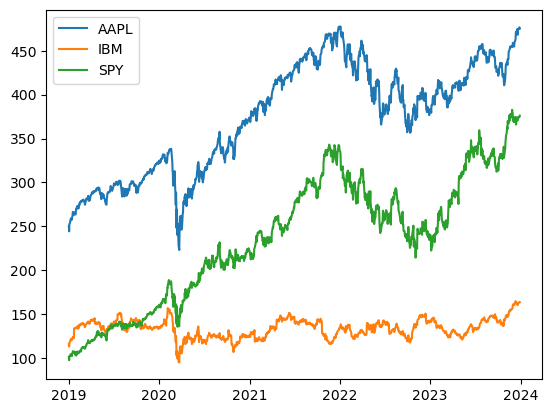

In [82]:
for name, data in tickers:
    plt.plot(dates, data.PRC.values, '-', label = name)
plt.legend()

In [84]:
def ts_split(ts, feature_steps=10, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps].flatten() for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps][:, -1]
                  for idx in range(n_obs)])
    return X, y

In [85]:
ts = {}
X = {}
y = {}
X_train_full = {}
y_train_full = {}
X_test = {}
y_test = {}
X_train = {}
y_train = {}
X_valid = {}
y_valid = {}
split_ind = {}
split_ind_2 = {}

features = ['PRC']  #features
scalers = {}

In [86]:
for name, data in tickers:
    data = data[features].dropna()
    #scalers[name] = StandardScaler()   
    scalers[name] = MinMaxScaler()
    data[features] = scalers[name].fit_transform(data[features])
    ts[name] = data[features].values
    
    X[name], y[name] = ts_split(ts[name])
    split_ind[name] = int(X[name].shape[0] * 0.8)
    X_train_full[name], y_train_full[name] = X[name][:split_ind[name]], y[name][:split_ind[name]]
    X_test[name], y_test[name] = X[name][split_ind[name]:], y[name][split_ind[name]:]
    split_ind_2[name] = int(X_train_full[name].shape[0] * 0.8)
    X_train[name], y_train[name] = X_train_full[name][:split_ind_2[name]], y_train_full[name][:split_ind_2[name]]
    X_valid[name], y_valid[name] = X_train_full[name][split_ind_2[name]:], y_train_full[name][split_ind_2[name]:]

In [87]:
#print(len(y_train_full['SPY']))
#print(len(X_train_full['SPY']))
#print(y_test['SPY'][1])
print(X_train['SPY'].shape)
print(y_train['SPY'].shape)
#print(data[features].shape)
print(data[features].shape)
print(ts['AAPL'])

(798, 10)
(798, 1)
(1258, 1)
[[0.10688488]
 [0.08345113]
 [0.11555975]
 ...
 [0.99528976]
 [0.99599627]
 [0.99057941]]


In [88]:
print(X_test['SPY'].shape)
print(y_train['SPY'].shape)
print(X_valid['SPY'][:1])
print(X_train['SPY'][:1])

(250, 10)
(798, 1)
[[0.69582896 0.67458809 0.63620748 0.62548196 0.66982122 0.65962143
  0.64027341 0.62754993 0.66508932 0.69046619]]
[[0.01303891 0.         0.01587802 0.01633368 0.01892744 0.02407992
  0.02173151 0.01892744 0.01629863 0.02667368]]


In [89]:
print(f"Training mean: {X_train['AAPL'].mean()}, Validation mean: {X_valid['AAPL'].mean()}")
print(f"Training std: {X_train['AAPL'].std()}, Validation std: {X_valid['AAPL'].std()}")

Training mean: 0.5080742419197254, Validation mean: 0.6993447863025901
Training std: 0.2585292362987853, Validation std: 0.09623431027365312


In [90]:
from keras.layers import SimpleRNN, Dense, Dropout
from keras.models import Sequential

def rnn_dense(input_shape, output_units):
    model = Sequential()
    
    model.add(SimpleRNN(units=64, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(TimeDistributed(Dense(units=32, activation='relu')))
    
    model.add(SimpleRNN(units=64, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))
    
    model.add(Dense(units=64, activation='relu'))
    model.add(Dense(units=32, activation='relu'))
    
    model.add(Dense(units=output_units))
    return model

In [91]:
from keras.layers import LSTM

def lstm_model(input_shape, output_units):
    model = Sequential()
    
    model.add(LSTM(units=64, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.2))
    
    model.add(LSTM(units=64, return_sequences=False))
    
    model.add(Dense(units=output_units))
    
    return model

In [92]:
def reset_session(seed):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    tf.keras.backend.clear_session()

Training RNN-Dense for ticker: AAPL


C:\Users\zjx68\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


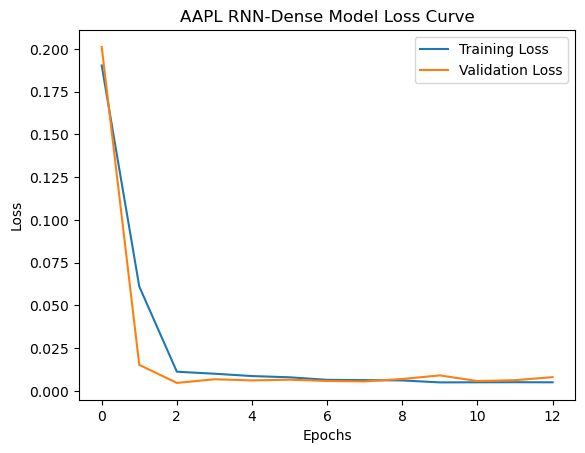

Test loss for AAPL using RNN-Dense: 0.008371696807444096
Training LSTM for ticker: AAPL


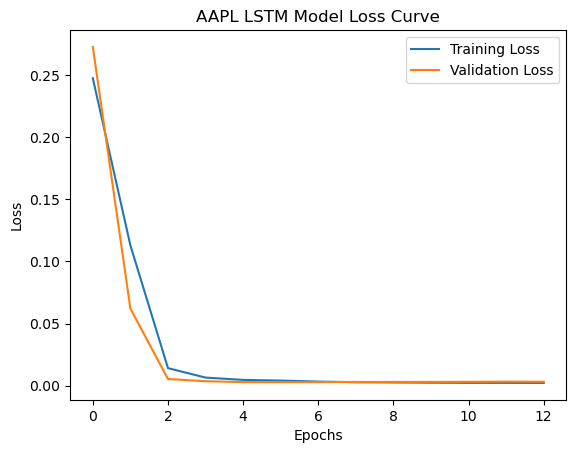

Test loss for AAPL using LSTM: 0.0015234954189509153
Training RNN-Dense for ticker: IBM


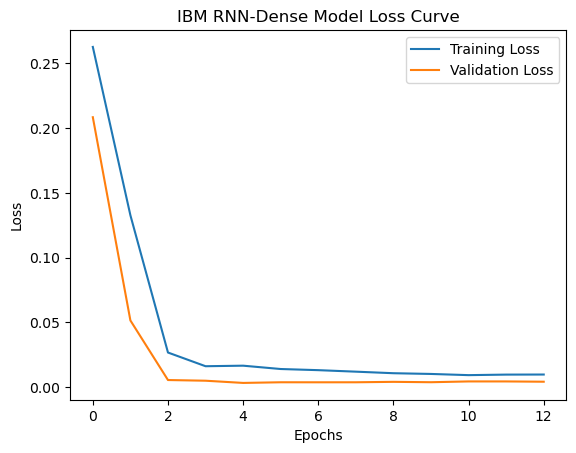

Test loss for IBM using RNN-Dense: 0.0038540582172572613
Training LSTM for ticker: IBM


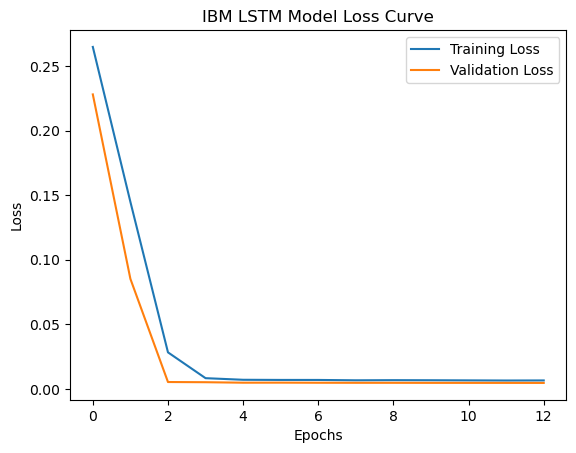

Test loss for IBM using LSTM: 0.004394547548145056
Training RNN-Dense for ticker: SPY


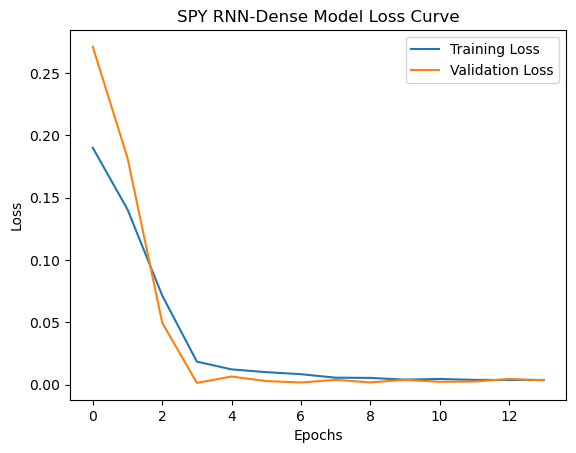

Test loss for SPY using RNN-Dense: 0.00811165850609541
Training LSTM for ticker: SPY


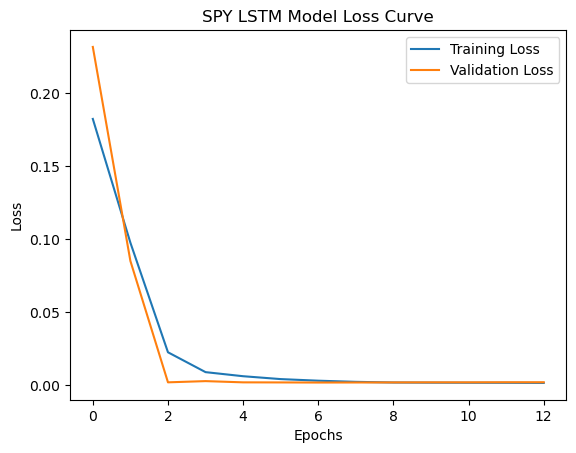

Test loss for SPY using LSTM: 0.007960504852235317


In [93]:
reset_session(42)
models = {}
histories = {}

for name in tickers.groups.keys():
    # Determine input shape for the RNN/LSTM (timesteps, features)
    input_shape = (X_train[name].shape[1], 1)
    output_units = y_train[name].shape[1] if len(y_train[name].shape) > 1 else 1

    for model_type, model_fn in [("RNN-Dense", rnn_dense), ("LSTM", lstm_model)]:
        print(f"Training {model_type} for ticker: {name}")
        
        # Build the model
        model = model_fn(input_shape, output_units)
        optimizer = Adam(learning_rate=0.0001)
        model.compile(optimizer=optimizer, loss='mean_squared_error')
        
        # Prepare y values
        y_train_values = y_train[name]
        y_valid_values = y_valid[name]
        
        # Early stopping
        early_stopping_cb = tf.keras.callbacks.EarlyStopping(
            patience=10, min_delta=0.01, restore_best_weights=True
        )
        
        # Train the model
        if len(X_train[name]) == len(y_train_values):
            history = model.fit(
                X_train[name],
                y_train_values,
                epochs=100,
                batch_size=32,
                validation_data=(X_valid[name], y_valid_values),
                callbacks=[early_stopping_cb],
                verbose=0,
            )
            
            # Save model and history
            models[f"{model_type}_{name}"] = model
            histories[f"{model_type}_{name}"] = history
            
            # Save model
            model.save(f"{model_type}_model_{name}.h5")
            
            # Plot loss curves
            plt.figure()
            plt.plot(history.history['loss'], label='Training Loss')
            plt.plot(history.history['val_loss'], label='Validation Loss')
            plt.title(f"{name} {model_type} Model Loss Curve")
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()
            
        # Evaluate on the test set
        test_loss = model.evaluate(X_test[name], y_test[name], verbose=0)
        print(f"Test loss for {name} using {model_type}: {test_loss}")

Evaluating RNN-Dense_AAPL for ticker: AAPL
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Ticker: AAPL, Model: RNN-Dense_AAPL, MSE: 543.3454925622283


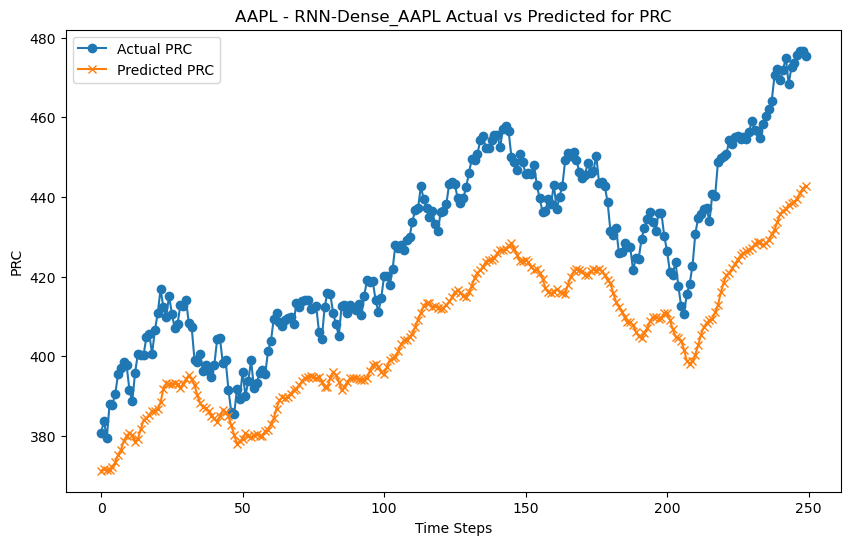

Evaluating LSTM_AAPL for ticker: AAPL
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step
Ticker: AAPL, Model: LSTM_AAPL, MSE: 98.87886198873107


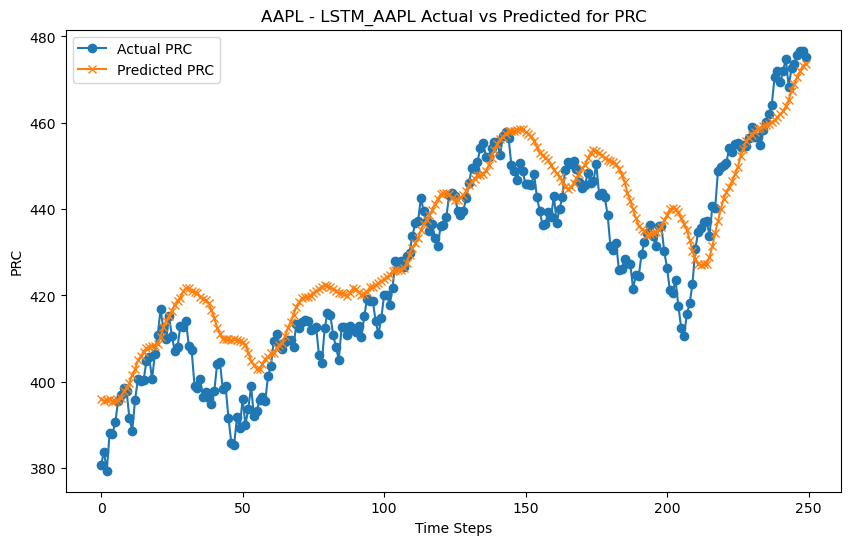

Evaluating RNN-Dense_IBM for ticker: IBM
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Ticker: IBM, Model: RNN-Dense_IBM, MSE: 18.852535077957125


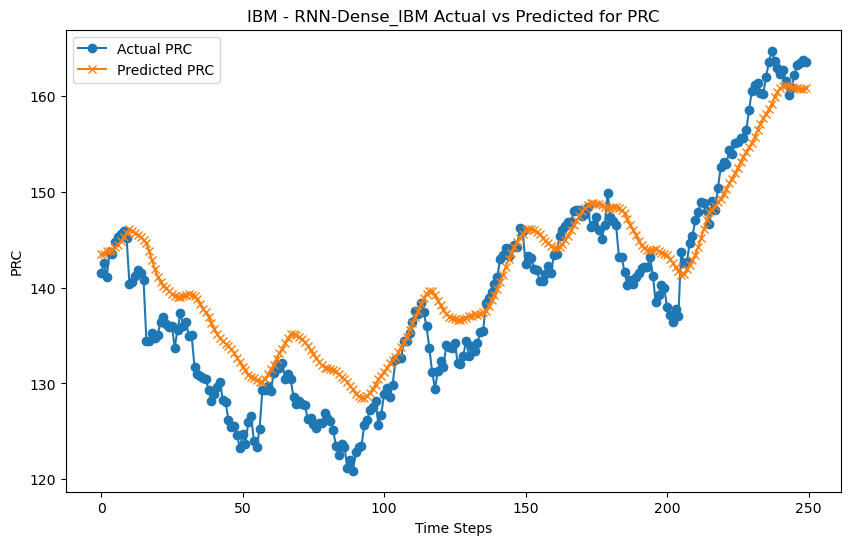

Evaluating LSTM_IBM for ticker: IBM
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step
Ticker: IBM, Model: LSTM_IBM, MSE: 21.496383673269893


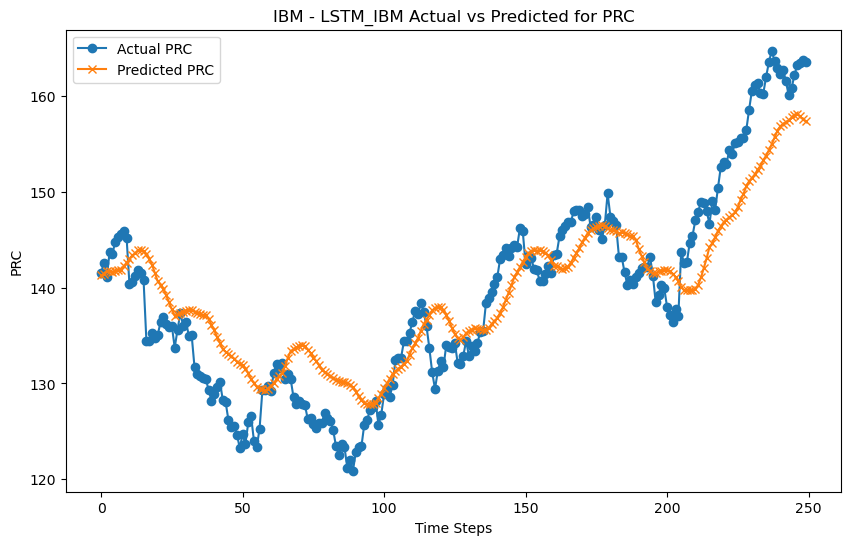

Evaluating RNN-Dense_SPY for ticker: SPY
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Ticker: SPY, Model: RNN-Dense_SPY, MSE: 660.2577098288136


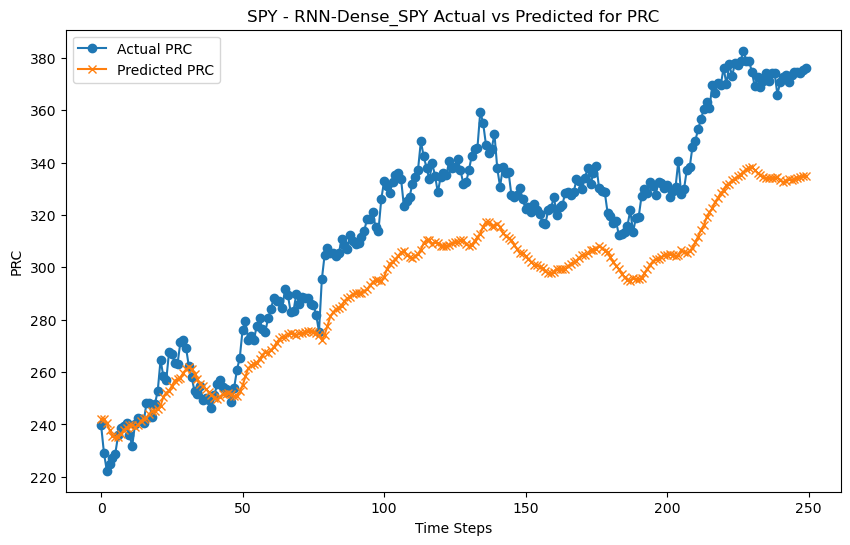

Evaluating LSTM_SPY for ticker: SPY
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step
Ticker: SPY, Model: LSTM_SPY, MSE: 647.9542744561319


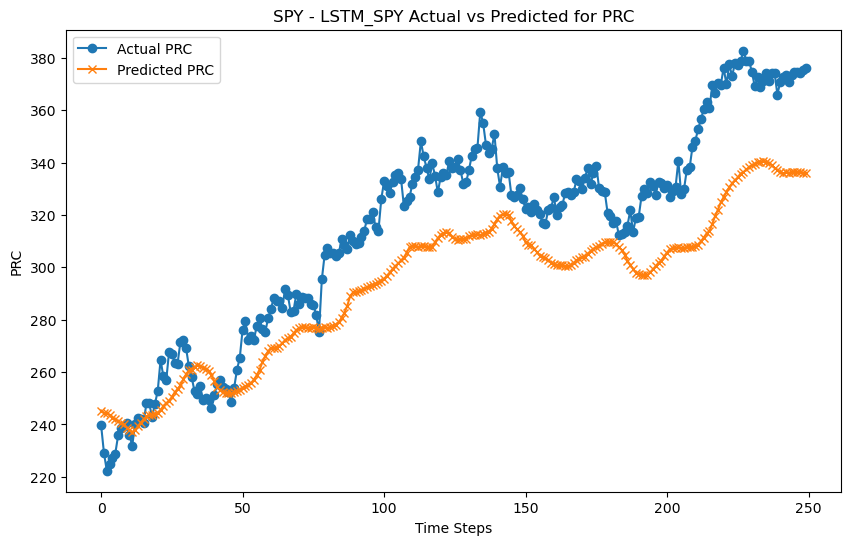

In [94]:
from sklearn.metrics import mean_squared_error

for model_key, model in models.items():
    # Extract the ticker name from the model_key (e.g., "RNN-Dense_AAPL" -> "AAPL")
    ticker = model_key.split('_')[-1]
    print(f"Evaluating {model_key} for ticker: {ticker}")

    # Get test data for the ticker
    X_test_values = X_test[ticker]
    y_test_values = y_test[ticker]

    # Make predictions
    y_pred = model.predict(X_test_values)

    # Inverse transform predictions and actual values
    y_test_original = scalers[ticker].inverse_transform(y_test_values)
    y_pred_original = scalers[ticker].inverse_transform(y_pred)

    # Calculate MSE
    mse = mean_squared_error(y_test_original, y_pred_original)
    print(f"Ticker: {ticker}, Model: {model_key}, MSE: {mse}")

    # Plot actual vs predicted
    for i, feature in enumerate(features):
        plt.figure(figsize=(10, 6))
        plt.plot(range(len(y_test_original)), y_test_original[:, i], label=f'Actual {feature}',linestyle='-', marker='o')
        plt.plot(range(len(y_pred_original)), y_pred_original[:, i], label=f'Predicted {feature}', linestyle='-', marker='x')
        plt.title(f"{ticker} - {model_key} Actual vs Predicted for {feature}")
        plt.xlabel('Time Steps')
        plt.ylabel(feature)
        plt.legend()
        plt.show()